In [179]:
# Some standard code imports
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np

# For drawing graphs
import networkx as nx

# Qiskit imports
from qiskit import Aer, execute, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal, RealAmplitudes, QFT, QuadraticForm
from qiskit.quantum_info import Statevector
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit_optimization.converters import LinearEqualityToPenalty, QuadraticProgramToQubo
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.translators import docplex_mp
from qiskit.opflow import I, Z, Zero, One, StateFn
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance

In [180]:
# Problem Formulation

In [181]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

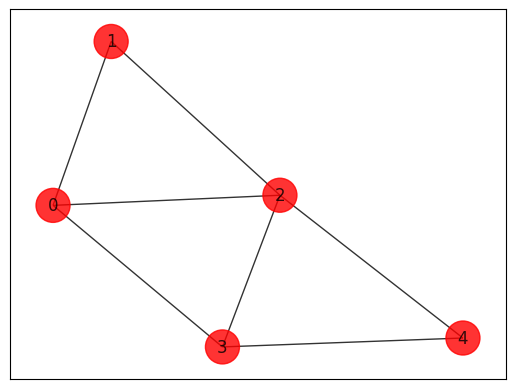

In [182]:
# Create graph
G = nx.Graph()

# Add 5 nodes
n = 5
G.add_nodes_from(range(n))

# Add edges: tuple is (i, j, weight) where (i, j) is the edge
edges = [(0,1,1.0), (0,2,1.0), (0,3,1.0), (1,2,1.0), (2,3,1.0), (2,4,1.0), (3,4,1.0)]
G.add_weighted_edges_from(edges)

# Plot graph
plot_result(G, [0]*n)

In [183]:
# Import a model from DOcplex
from docplex.mp.model import Model

# Name the model
mdl = Model('MaxCut')

# Add a binary variable to the model for each node in the graph
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

# Define the objective function
objective = mdl.sum([w * (x[i] + x[j] - 2*x[i] * x[j]) for (i, j, w) in edges])

# Add an equality constraint
b = 2
mdl.add_constraint(mdl.sum(x)==b)

# And let's maximize it
mdl.maximize(objective)

# Let's print the model
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {
 x0 + x1 + x2 + x3 + x4 == 2;

}


In [184]:
# Quadratic Problem

In [185]:
from qiskit_optimization.translators import from_docplex_mp

# Instantiate an empty QuadraticProgram object
qp = QuadraticProgram()

# Put the model inside it
qp = from_docplex_mp(mdl)

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 + [ - 4 x0*x1 - 4 x0*x2 - 4 x0*x3
      - 4 x1*x2 - 4 x2*x3 - 4 x2*x4 - 4 x3*x4 ]/2
Subject To
 c0: x0 + x1 + x2 + x3 + x4 = 2

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



In [186]:
qp.objective.linear.to_dict()

{0: 3.0, 1: 2.0, 2: 4.0, 3: 3.0, 4: 2.0}

In [187]:
qp.objective.quadratic.to_dict()

{(0, 1): -2.0,
 (0, 2): -2.0,
 (1, 2): -2.0,
 (0, 3): -2.0,
 (2, 3): -2.0,
 (2, 4): -2.0,
 (3, 4): -2.0}

In [188]:
# Classical Solution

fval=5.0, x0=1.0, x1=0.0, x2=1.0, x3=0.0, x4=0.0, status=SUCCESS


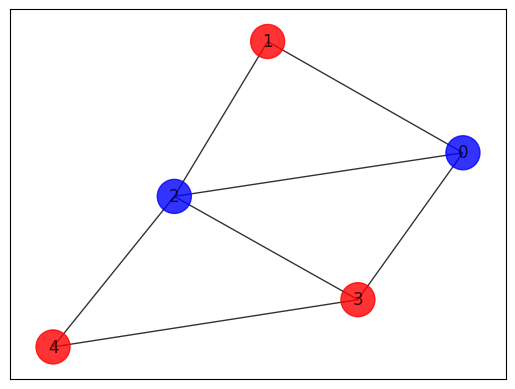

In [189]:
solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = solver.solve(qp)
print(result)
plot_result(G, result.x)

In [190]:
# Convert to QUBO

In [191]:
eq_converter = LinearEqualityToPenalty()
qp_eq = eq_converter.convert(qp)
print(qp_eq.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 119 x0 + 118 x1 + 120 x2 + 119 x3 + 118 x4 + [ - 58 x0^2 - 120 x0*x1
      - 120 x0*x2 - 120 x0*x3 - 116 x0*x4 - 58 x1^2 - 120 x1*x2 - 116 x1*x3
      - 116 x1*x4 - 58 x2^2 - 120 x2*x3 - 120 x2*x4 - 58 x3^2 - 120 x3*x4
      - 58 x4^2 ]/2 -116
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



In [192]:
direct_translation = QuadraticProgramToQubo(penalty=10).convert(qp)

# Let's print the model!
print(direct_translation.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Minimize
 obj: - 43 x0 - 42 x1 - 44 x2 - 43 x3 - 42 x4 + [ 20 x0^2 + 44 x0*x1 + 44 x0*x2
      + 44 x0*x3 + 40 x0*x4 + 20 x1^2 + 44 x1*x2 + 40 x1*x3 + 40 x1*x4 + 20 x2^2
      + 44 x2*x3 + 44 x2*x4 + 20 x3^2 + 44 x3*x4 + 20 x4^2 ]/2 + 40
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End



In [193]:
# Ising Model

In [194]:
print('I =   \n', I.to_matrix())
print('Z =   \n', Z.to_matrix())
print('|0> = \n', Zero.to_matrix())
print('|1> = \n', One.to_matrix())

I =   
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Z =   
 [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]
|0> = 
 [1.+0.j 0.+0.j]
|1> = 
 [0.+0.j 1.+0.j]


In [195]:
print('<0|Z|0> = ', (~StateFn(Z) @ Zero).eval())
print('<1|Z|1> = ', (~StateFn(Z) @ One).eval())

<0|Z|0> =  (1+0j)
<1|Z|1> =  (-1+0j)


In [196]:
print('ZZ =   \n', (Z ^ Z).to_matrix())
print()
print('|0>|0> = ', (Zero ^ Zero).to_matrix())
print('|0>|1> = ', (Zero ^ One).to_matrix())
print('|1>|0> = ', (One ^ Zero).to_matrix())
print('|1>|1> = ', (One ^ One).to_matrix())

ZZ =   
 [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]

|0>|0> =  [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
|0>|1> =  [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
|1>|0> =  [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
|1>|1> =  [0.+0.j 0.+0.j 0.+0.j 1.+0.j]


In [197]:
print('<00|ZZ|00> = ', (~StateFn(Z^Z) @ (One^One)).eval())
print('<01|ZZ|01> = ', (~StateFn(Z^Z) @ (One^Zero)).eval())
print('<10|ZZ|10> = ', (~StateFn(Z^Z) @ (Zero^One)).eval())
print('<11|ZZ|11> = ', (~StateFn(Z^Z) @ (One^One)).eval())

<00|ZZ|00> =  (1+0j)
<01|ZZ|01> =  (-1+0j)
<10|ZZ|10> =  (-1+0j)
<11|ZZ|11> =  (1+0j)


In [198]:
# define Hamiltonian
H = I ^ I ^ Z ^ Z ^ I

# define state
psi = Zero ^ One ^ Zero ^ One ^ Zero

# evaluate expected value
print('<psi|H|psi> = ', (~StateFn(H) @ psi).eval())

<psi|H|psi> =  (-1+0j)


In [199]:
H, offset = qp_eq.to_ising()
print('offset = ', offset)
print('H = ', H)

offset =  40.0
H =  -14.5 * IIIIZ
- 14.5 * IIIZI
- 14.5 * IIZII
- 14.5 * IZIII
- 14.5 * ZIIII
+ 15.0 * IIIZZ
+ 15.0 * IIZIZ
+ 15.0 * IIZZI
+ 15.0 * IZIIZ
+ 14.5 * IZIZI
+ 15.0 * IZZII
+ 14.5 * ZIIIZ
+ 14.5 * ZIIZI
+ 15.0 * ZIZII
+ 15.0 * ZZIII


Minimum energy for Hamiltonian: -45.0


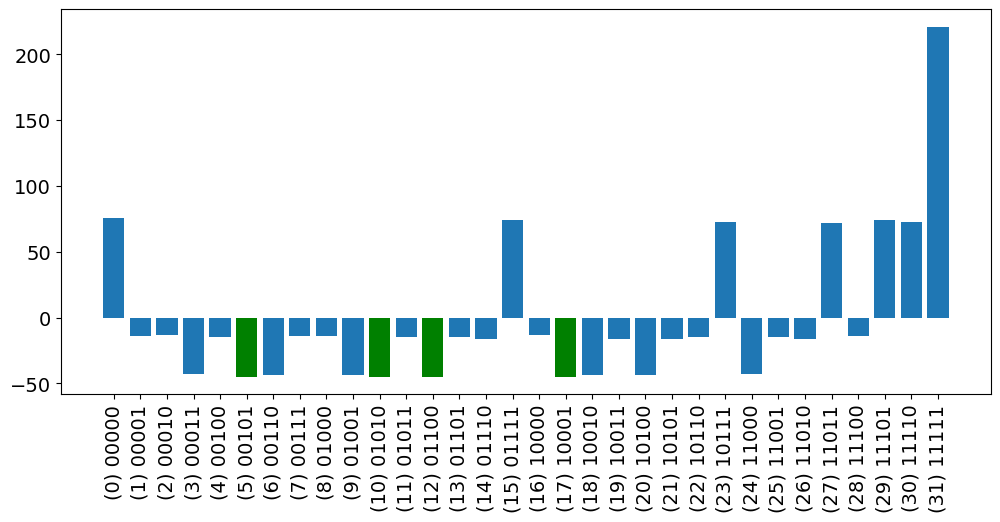

In [200]:
H_matrix = np.real(H.to_matrix())

# Get the set of basis states which have the lowest energy
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 5))

print('Minimum energy for Hamiltonian: {0}'.format(min(H_matrix.diagonal())))
# Plot the expectation value of the energy of different basis states,
# and color those basis states which would have the lowest energy
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [201]:
# VQE Algorithm

energy:  -44.66361061840324
time:  2.789231061935425
max-cut objective:  -4.66361061840324


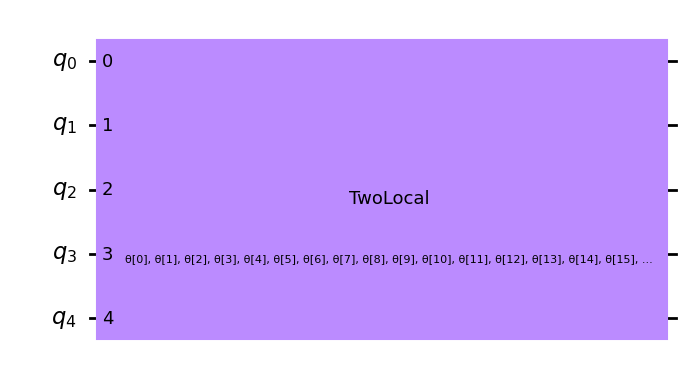

In [202]:
seed = 10598
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(H.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(H)

# print results
print('energy: ', result.eigenvalue.real)
print('time: ', result.optimizer_time)
print('max-cut objective: ', result.eigenvalue.real + offset)
ry.draw('mpl')

In [203]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = 1
print(w)

[[0. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


In [204]:
max_cut = Maxcut(w)
x = max_cut.sample_most_likely(result._eigenstate)
print('solution: ', x)
print('solution objective: ', qp.objective.evaluate(x))

solution:  [0. 1. 0. 1. 0.]
solution objective:  5.0


In [205]:
# Trotterized Annealing

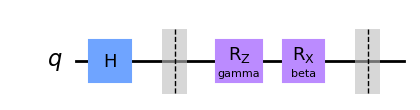

In [206]:
gamma, beta = Parameter('gamma'), Parameter('beta')

# This circuit would be 1 time step
qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
qc.rz(gamma, 0)
qc.rx(beta, 0)
qc.barrier()
qc.draw('mpl')

In [207]:
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], [] # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [2 * delta_t * t/T] # H_C
        betas += [-2 * delta_t * (1 - t/T)] # H_X
    return gammas, betas

T = 5
N = 10
gammas, betas = construct_schedule(T, N)

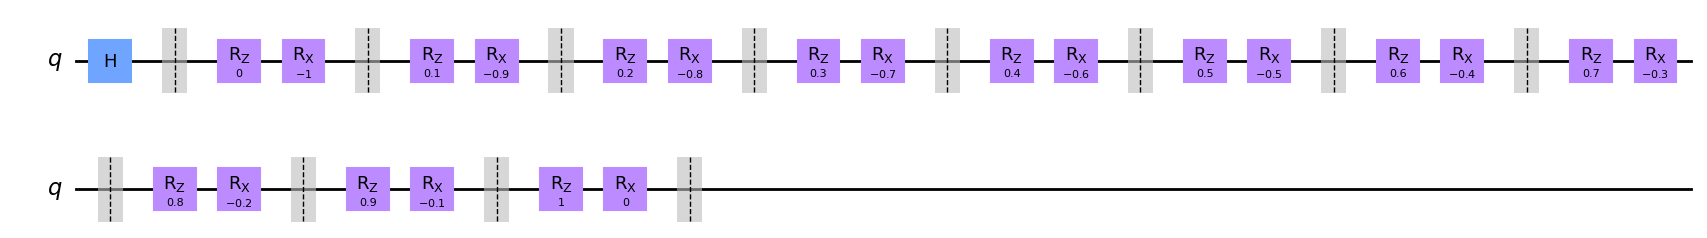

In [208]:
probabilities = np.zeros((2, N+1))

# Set up the circuit
qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
# Do the evolution
for i, (gamma, beta) in enumerate(zip(gammas, betas)):
    qc.rz(gamma, 0)
    qc.rx(beta, 0)
    qc.barrier()
    # Simulate the circuit, and store the probabilities of |0> and |1> at each timestop
    probabilities[:, i] = Statevector.from_instruction(qc).probabilities()

qc.draw('mpl')

In [209]:
# Grover Optimization

In [210]:
def twos_complement(val, num_bits):
    val = int(val, 2)
    if (val & (1 << (num_bits - 1))) != 0:
        val = val - (1 << num_bits)
    return val

print(twos_complement('0000', 4))
print(twos_complement('0101', 4))
print(twos_complement('1010', 4))
print(twos_complement('1111', 4))

0
5
-6
-1


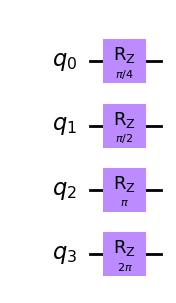

In [211]:
def encode(num_qubits, k):
    qc = QuantumCircuit(num_qubits, name='enc({})'.format(k))
    for j in range(num_qubits):
        # Angle of rotation
        theta = 2*np.pi * 2**j / 2**num_qubits * k
        qc.rz(theta, j)
    return qc

encode(4, 2).draw('mpl')

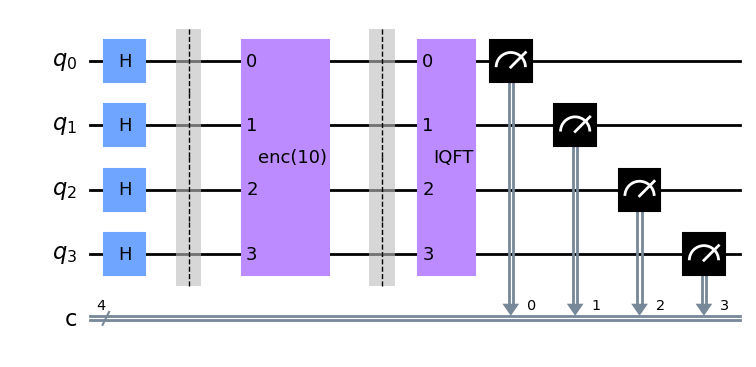

In [212]:
num_value_qubits = 4
num_to_encode = 10

qc = QuantumCircuit(num_value_qubits, num_value_qubits)
qc.h(range(num_value_qubits))
qc.barrier()
qc.append(encode(num_value_qubits, num_to_encode), range(num_value_qubits))
qc.barrier()
qc.append(QFT(num_value_qubits, do_swaps=True, inverse=True), qc.qubits)

# Note: we have to mess around with the bitstring ordering here
# in order for the two's compliment math to work out
qc.measure(qc.qregs[0], qc.cregs[0])

qc.draw('mpl', fold=120)

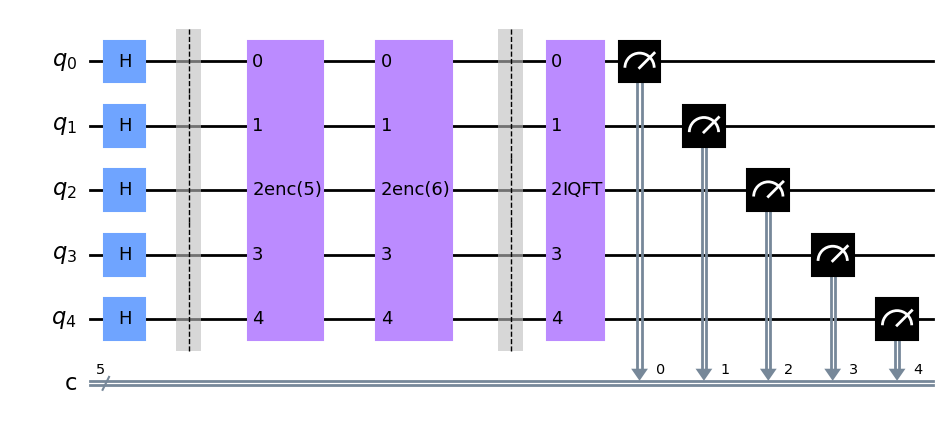

In [213]:
num_value_qubits = 5
num_to_encode = 5

qc = QuantumCircuit(num_value_qubits, num_value_qubits)
qc.h(range(num_value_qubits))
qc.barrier()
qc.append(encode(num_value_qubits, num_to_encode), range(num_value_qubits))
qc.append(encode(num_value_qubits, num_to_encode+1), range(num_value_qubits))
qc.barrier()
qc.append(QFT(num_value_qubits, do_swaps=True, inverse=True), qc.qubits)

# Note: we have to mess around with the bitstring ordering here
# in order for the two's compliment math to work out
qc.measure(qc.qregs[0], qc.cregs[0])

qc.draw('mpl', fold=120)

In [214]:
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
for key in counts:
    print(key, ' -->', twos_complement(key, num_value_qubits))

01011  --> 11


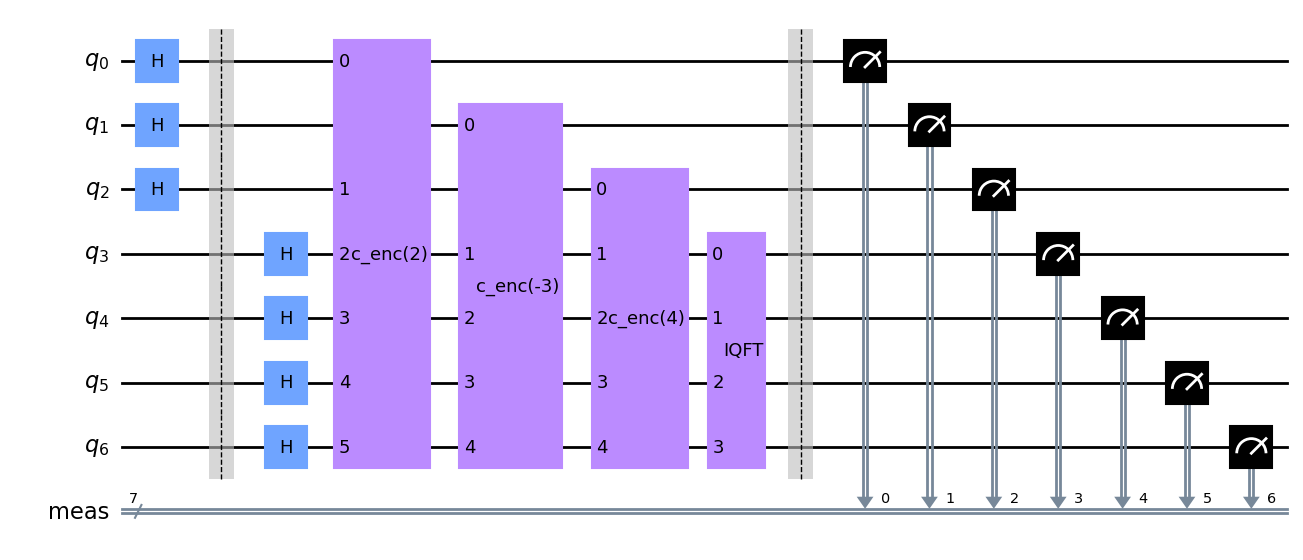

In [215]:
num_input_qubits = 3
num_value_qubits = 4
num_total_qubits = num_input_qubits + num_value_qubits
qc = QuantumCircuit(num_total_qubits)
qc.h([0,1,2])
qc.barrier()
qc.h(range(num_input_qubits, num_total_qubits))
qc.append(encode(num_value_qubits, 2).control(2), [0,2]+list(range(num_input_qubits, num_total_qubits)))
qc.append(encode(num_value_qubits, -3).control(), [1]+list(range(num_input_qubits, num_total_qubits)))
qc.append(encode(num_value_qubits, 4).control(), [2]+list(range(num_input_qubits, num_total_qubits)))
qc.append(QFT(num_value_qubits, do_swaps=True, inverse=True), range(num_input_qubits, num_total_qubits))
qc.measure_all()
qc.draw('mpl')

In [216]:
counts = execute(qc, Aer.get_backend('qasm_simulator')).result().get_counts()
for key, value in counts.items():
    x = key[num_value_qubits:]
    y_bin = key[:num_value_qubits]
    y_int = twos_complement(y_bin, num_value_qubits)
    print(key, '-->', y_bin, '-->', y_int, '\t(counts: {})'.format(value))

1101010 --> 1101 --> -3 	(counts: 118)
0001110 --> 0001 --> 1 	(counts: 130)
0011111 --> 0011 --> 3 	(counts: 143)
0000000 --> 0000 --> 0 	(counts: 130)
0110101 --> 0110 --> 6 	(counts: 117)
1101011 --> 1101 --> -3 	(counts: 131)
0100100 --> 0100 --> 4 	(counts: 121)
0000001 --> 0000 --> 0 	(counts: 134)


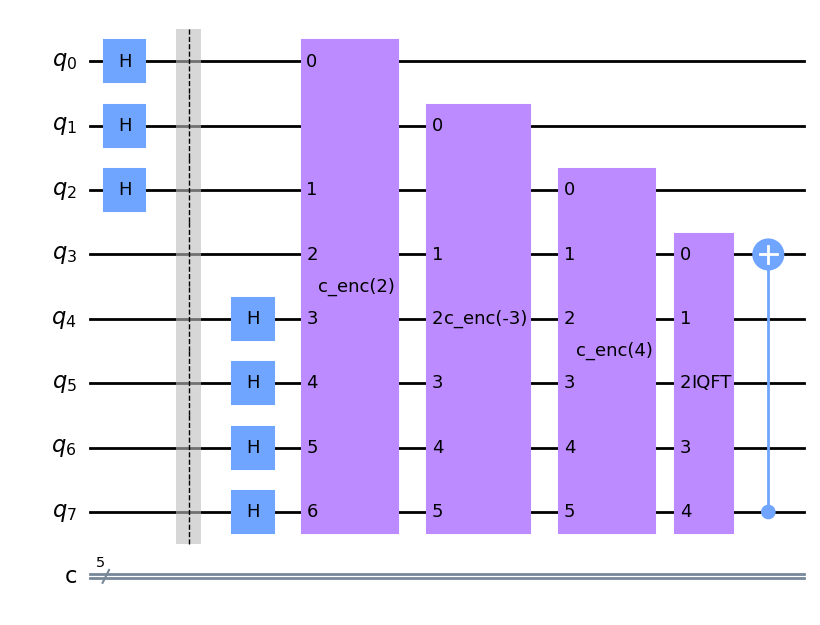

In [233]:
num_input_qubits = 3
num_value_qubits = 5
num_total_qubits = num_input_qubits + num_value_qubits
qc = QuantumCircuit(num_total_qubits, num_value_qubits)
qc.h([0,1,2])
qc.barrier()
qc.h(range(num_input_qubits+1, num_total_qubits))
qc.append(encode(num_value_qubits, 2).control(2), [0,2]+list(range(num_input_qubits, num_total_qubits)))
qc.append(encode(num_value_qubits, -3).control(), [1]+list(range(num_input_qubits, num_total_qubits)))
qc.append(encode(num_value_qubits, 4).control(), [2]+list(range(num_input_qubits, num_total_qubits)))
qc.append(QFT(num_value_qubits, do_swaps=True, inverse=True), range(num_input_qubits, num_total_qubits))
qc.cx(num_total_qubits-1, num_input_qubits)
qc.draw('mpl')

In [234]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation /s> -> /00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation /00..0> -> /11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1) # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation /11..1> -> /00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation /00..0> -> /s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

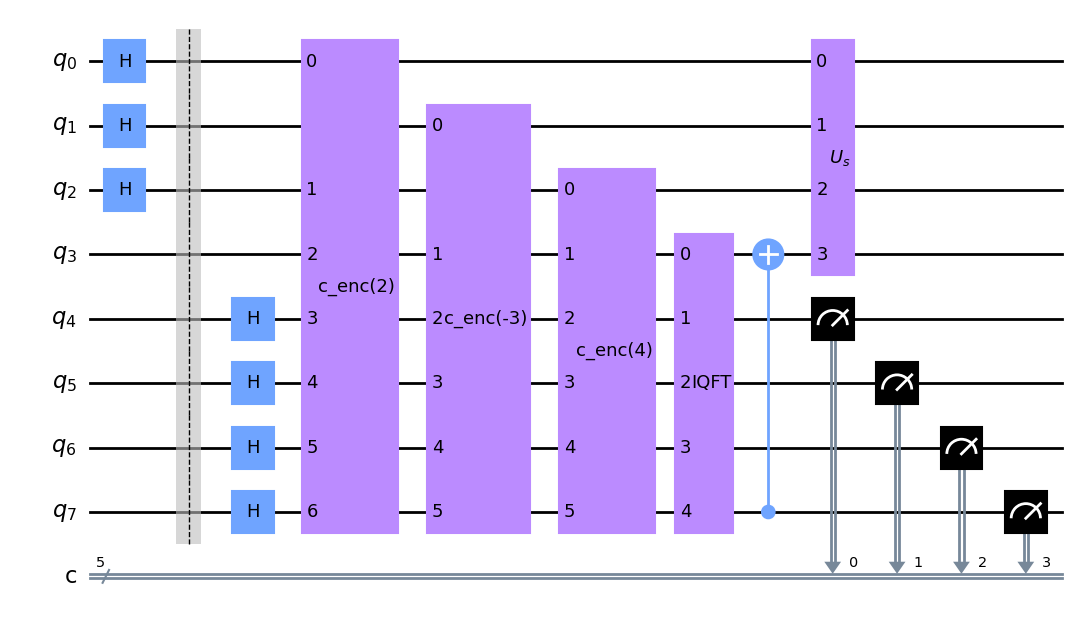

In [235]:
qc.append(diffuser(4), range(4))
qc.measure(range(4,8), range(4))
qc.draw('mpl')

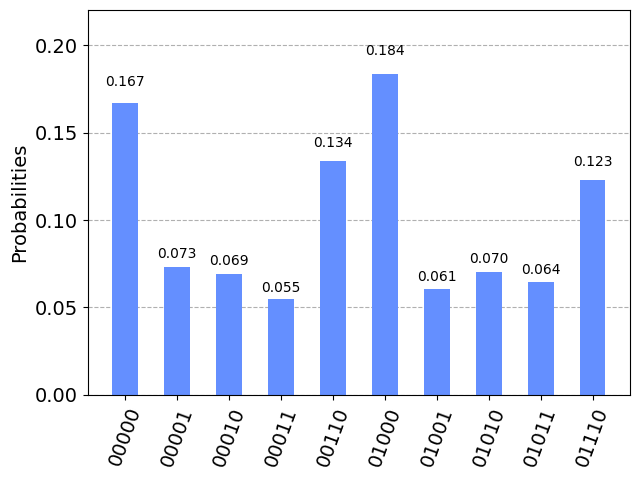

In [236]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

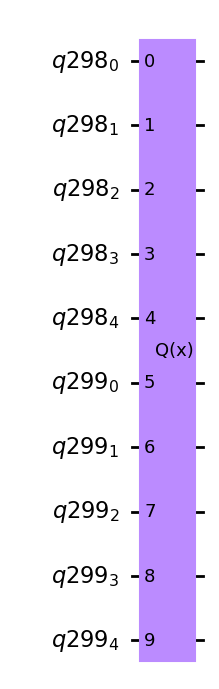

In [237]:
qp_eq = QuadraticProgramToQubo(penalty=1).convert(qp)

A = qp_eq.objective.quadratic.to_array()
b = qp_eq.objective.linear.to_array()
c = qp_eq.objective.constant

# set number of results qubits
num_value_qubits = 5

# construct circuit to evaluate quadratic form
qf = QuadraticForm(num_value_qubits, A, b, c)
qf.draw('mpl', fold=120)

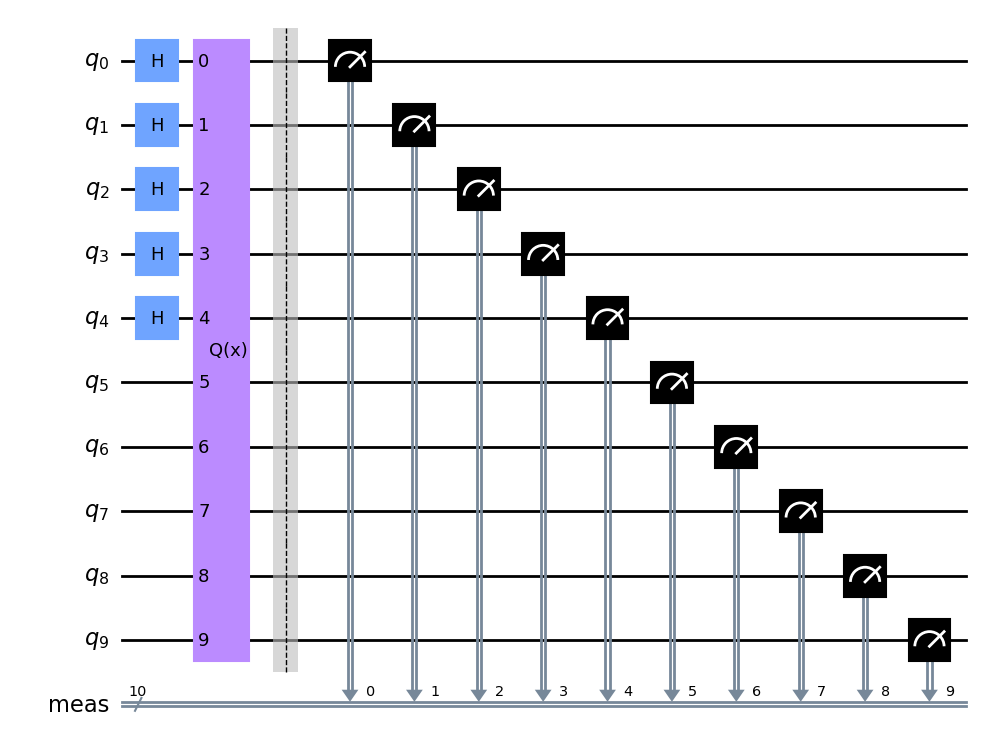

In [239]:
qc = QuantumCircuit(n + num_value_qubits)

# Initialize the data qubits to be a superposition state
qc.h(range(n))

# Add the circuit which evaluates the objective function
qc.append(qf, range(n + num_value_qubits))
qc.measure_all()
qc.draw('mpl')

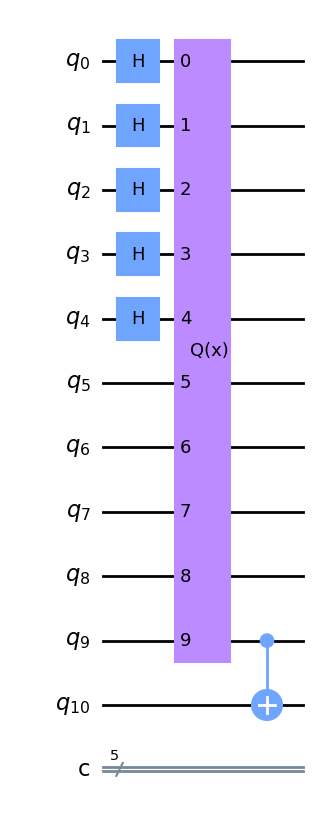

In [245]:
qc_grover = QuantumCircuit(n + num_value_qubits + 1, n)

# _groverInitialize the data qubits to be a superposition state
qc_grover.h(range(n))

# _groverAdd the circuit which evaluates the objective function
qc_grover.append(qf, range(n + num_value_qubits))
qc_grover.cx(n + num_value_qubits - 1, n + num_value_qubits)
qc_grover.draw('mpl')

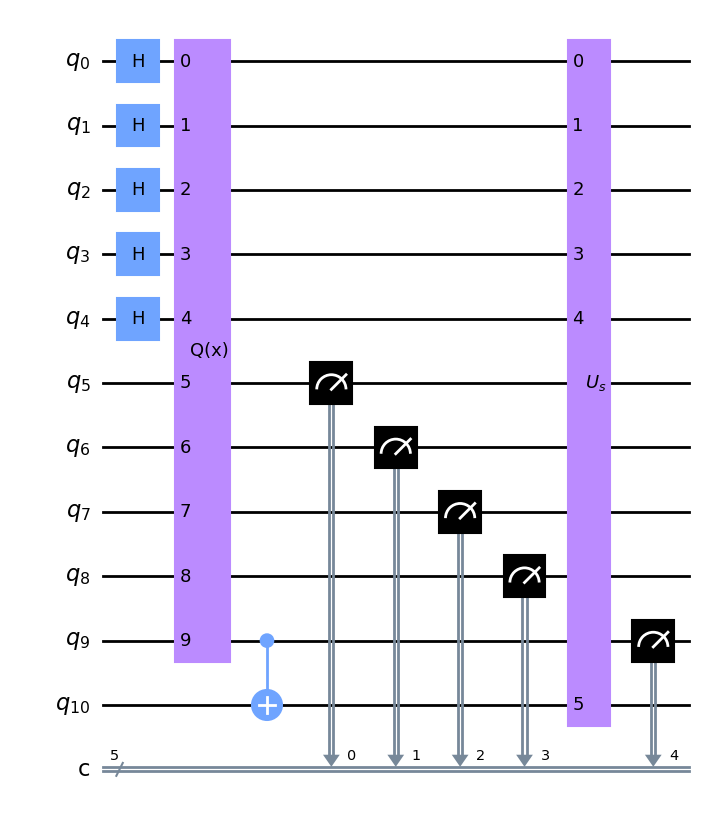

In [246]:
qc_grover.append(diffuser(n+1), [0,1,2,3,4,10])
qc_grover.measure(range(5,10), range(5))
qc_grover.draw('mpl')

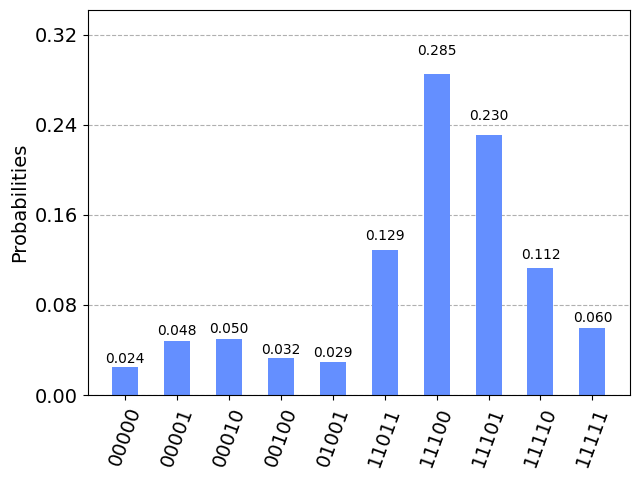

In [248]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc_grover, backend, shots=1024).result()
counts = results.get_counts()
plot_histogram(counts)

In [250]:
from qiskit_optimization.algorithms import GroverOptimizer

backend = Aer.get_backend('statevector_simulator')

grover_optimizer = GroverOptimizer(10, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print(results.status)
print('x={}'.format(results.x))
print('fval={}'.format(results.fval))

OptimizationResultStatus.SUCCESS
x=[1. 0. 1. 0. 0.]
fval=5.0


In [251]:
grover_optimizer = GroverOptimizer(7, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print(results.status)
print('x={}'.format(results.x))
print('fval={}'.format(results.fval))

OptimizationResultStatus.INFEASIBLE
x=[1. 1. 0. 1. 1.]
fval=4.0
